In [117]:
import torch
from torchvision import models
import matplotlib.pyplot as plt

# Load pretrained DeepLabV3 with a ResNet-101 backbone
# model = models.segmentation.deeplabv3_resnet101(pretrained=True)
# model.eval()  # Set to evaluation mode

In [118]:
# # segformer

# # Stable release
# !pip install numpy==1.26.4
# !pip install transformers
# # If you want PyTorch + Transformers
# !pip install torch torchvision transformers

In [119]:
# dataloader

print('This will give you dataset of ade20k challenge with 150')

import importlib
import data.ade20k_challenges
importlib.reload(data.ade20k_challenges)
from data.ade20k_challenges import ADE20k_challange
from torchvision import transforms, datasets
from torchvision.transforms import InterpolationMode

im_size = 512 

transform_train_no_np = transforms.Compose([
    transforms.Resize((im_size, im_size),  interpolation=InterpolationMode.NEAREST),  # Resize the image
    transforms.PILToTensor()  # Convert to uint8 tensor array [c, h, w]
])

dataset_train = ADE20k_challange('dataset/ADEChallengeData2016/' , transform=transform_train_no_np, data_set = 'validation',
                                 color_pallete = None, img_size = im_size, aug = False)
batch_size = 32
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
# label number to label classese
# https://docs.google.com/spreadsheets/d/1se8YEtb2detS7OuPE86fXGyD269pMycAWe2mtKUj2W8/edit?gid=0#gid=0

This will give you dataset of ade20k challenge with 150


In [3]:
# CocoStuff 164k MAhmed
# batch 32 works in edith server

print('This will give you dataset of Coco164k with 182 labels')

import importlib
import data.cocostuff
importlib.reload(data.cocostuff)
from data.cocostuff import COCOStuff164k


dataset_train = COCOStuff164k('dataset/cocostuff164k/' , transform=transform_train_no_np, data_set = 'val2017',
                               img_size = im_size, aug = False)
batch_size = 32
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
# label number to label classese
# https://github.com/nightrome/cocostuff/blob/master/labels.txt

This will give you dataset of Coco164k with 182 labels


In [3]:
import data.augmentation_script
import data.ade20k
importlib.reload(data.augmentation_script)
importlib.reload(data.ade20k)
from data.augmentation_script import _augmentation_gpu


In [4]:
# deeplabv3 preprecessing (the input should be value of to 0-1)
dl_preprocess = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])
device = 'cuda'

In [5]:
import deeplabv3_models, segformer_models
importlib.reload(deeplabv3_models)
importlib.reload(segformer_models)

from deeplabv3_models import CustomDeepLabV3, MeruDeepLabV3
from segformer_models import CustomSegformer, MeruSegformer

# model =  CustomDeepLabV3(151) # 183 for coco # 151 for ade
# model = MeruDeepLabV3(183, 64, entail_weight = 0.2)
# model = CustomSegformer(num_classes= 151)

model = MeruSegformer(num_classes= 151)

model = model.to(device)

In [6]:
# loading the prototypes for the MERU model
import torch.nn as nn
text_feats_pca = torch.load("class_embeddings_word/Ade_151_pca_bse1_5_64D.pt")
# text_feats_pca = torch.load("class_embeddings_word/Coco_183_pca_bse1_5_64D.pt")
text_feats = text_feats_pca.squeeze(dim = 1)
model.text_protos = nn.Parameter(text_feats.clone().to(device), requires_grad = False) 

In [7]:
# Define parameter groups

import torch.optim as optim


lr1 = 0.0007
lr2 = 0.0009
lr3 = 0.0001  # example


print('careful about the weights as model changes')


# optimizer = optim.SGD([
#     {"params": model.backbone.parameters(), "lr": lr1},
#     {"params": list(model.head.parameters()) + list(model.classifier.parameters()), "lr": lr2}
# ], momentum=0.9, weight_decay=1e-4)

lr_encoder = 1e-5
lr_decoder = 1e-4

optimizer = optim.AdamW([
        {"params": model.encoder.parameters(), "lr": lr_encoder},   # encoder (pretrained backbone)
        {"params": model.decode_head.parameters(), "lr": lr_decoder} # decoder (newly added head)
    ], weight_decay=1e-4) # segformer optimizer

# optimizer = optim.SGD([
#     # Backbone
#     {"params": model.backbone.parameters(), "lr": lr1},
#     # Head, classifier, feats
#     {"params": list(model.head.parameters()) +
#                list(model.classifier.parameters()) +
#                list(model.feats.parameters()), "lr": lr2},
#     # Single parameters (alphas, curvature, logit scale, etc.)
#     {"params": [model.logit_scale,
#                 model.textual_alpha,
#                 model.image_alpha,
#                 model.curv], "lr": lr3}
# ], momentum=0.9, weight_decay=1e-4)


# optimizer = optim.AdamW([
#     {"params": model.backbone.parameters(), "lr": lr1},
#     {"params": list(model.head.parameters()) + list(model.classifier.parameters()), "lr": lr2}
# ], weight_decay=1e-4)

# optimizer = optim.Adam([
#     {"params": model.backbone.parameters(), "lr": lr1},
#     {"params": list(model.head.parameters()) + list(model.classifier.parameters()), "lr": lr2}
# ], weight_decay=1e-4)

criterion = torch.nn.CrossEntropyLoss()

careful about the weights as model changes


In [11]:
print('Training loop for the BASELINE model')
import random
import pdb
for epoch in range(1):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        try:
            inputs, labels, _  = data
        except: 
            inputs, labels = data
            
        inputs = inputs.to(device)
        labels = labels.squeeze().to(device)
        inputs, labels  = _augmentation_gpu(inputs.float(), labels, augmentation_num = random.randint(0, 1), im_size= im_size) # input -> bs, 3, h, w ; labels -> bs, h, w
        inputs = dl_preprocess(inputs.float()/255.0).to(device) # deeplab specific transformation. 
        
        # be mindful to check the image size after the augmentation for testing. 
        
        labels = labels.long()
        
        break
        #

        optimizer.zero_grad()
        
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.cpu().item()
        
        
        
        if i% 1000 ==0:
            pred = torch.argmax(outputs, dim=1)
            # Check if predictions match the ground truth (shape: B, H, W)
            correct = (pred == labels).float()  # Convert to float to compute mean
            # Compute the pixel-wise accuracy
            accuracy = correct.sum() / (labels.numel())  # numel() gives total number of elements
            print('Accuracy: ', accuracy)
            print('loss value: ', loss.item())

            break

print('Finished Training')

Training loop for the BASELINE model
Finished Training


In [102]:
print('Training loop for hyperbolic Meru Model')
# model should be MeruDeepLabV3 class
import random
import pdb

for epoch in range(1):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        try:
            inputs, labels, _  = data
        except: 
            inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.squeeze().to(device)
        inputs, labels  = _augmentation_gpu(inputs.float(), labels, augmentation_num = random.randint(0, 0), im_size= im_size) # input -> bs, 3, h, w ; labels -> bs, h, w
        inputs = dl_preprocess(inputs.float()/255.0).to(device) # deeplab specific transformation. 
        # be mindful to check the image size after the augmentation for testing. 
        labels = labels.long()
        
        if labels.max() > 182:
            pdb.set_trace()
        
        optimizer.zero_grad()
        
        outputs = model(inputs, labels)           # outputs is a dict
        loss = outputs["loss"]
        
        if torch.isnan(loss):
            print(f"[NaN Detected] Epoch {epoch} Step {step}")
            print("Logging:", outputs.get("logging", {}))
            pdb.set_trace()   # drop into debugger

        loss.backward()
        
        ### check the clip gradient for unstability
        # clip_value = 1.0
        # torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        optimizer.step()

        running_loss += loss.item()
        if i% 1000 ==0:
            with torch.no_grad():
                print(loss.item())
            
            break
            

print('Finished Training')
# if cuda error happens check if the number of labels is greater than the number of logits

Training loop for hyperbolic Meru Model
0.539792537689209
Finished Training


In [103]:
input('Make sure you know, what you want to do here: Abort if not sure')
PATH = 'saved_models/MERU_segformer_b4_100_hub_ade.pth' # check the model before loading. 
# torch.save(model.state_dict(), PATH)

state_dict = torch.load(PATH, map_location=device)
missing, unexpected = model.load_state_dict(state_dict, strict=False)

Make sure you know, what you want to do here: Abort if not sure 


In [104]:
from Utils_Loss_Vis import image_gen, ss_metrics
importlib.reload(image_gen)

<module 'Utils_Loss_Vis.image_gen' from '/notebooks/sam_1/segment-anything/Utils_Loss_Vis/image_gen.py'>

In [105]:
# inference loop for hyperbolic mode

# Lorentz Analysis
import os
import sys
sys.path.append('..')  # relative to notebook location
from MERU_utils import lorentz as L
importlib.reload(L)


# inference loop 
model.eval
with torch.no_grad():
    image_feats_d = model.image_encoder(inputs, True)
    text_feats_d = model.text_encoder(True)
    logits1 = - L.pairwise_dist(image_feats_d, text_feats_d[[0,1,3,6, 18]], model.curv.exp()) # full distance spectrun bs, h, w, class_num
    # angles = L.oxy_angle(text_feats_d[labels], image_feats_d)
    an, dist, aper_ = L.oxy_angle_modified(image_feats_d, text_feats_d, labels, model.curv.exp())
    logits = - dist
    angles_full = L.oxy_angle_full(image_feats_d, text_feats_d) # full angle spectrun bs, h, w, class_num
    logits = model(inputs, None)
    
##
# labels_exp = labels.unsqueeze(-1)
# # Gather along the last dimension (dim=3)
# angle__= torch.gather(angles_full, dim=3, index=labels_exp).squeeze(-1)
# # c= torch.gather(c, dim=3, index=labels_exp).squeeze(-1)
inputs_s = (inputs - torch.min(inputs))/ (torch.max(inputs) - torch.min(inputs))


In [106]:
pred = logits['logits'].argmax(-1)
pred1 = logits1.argmax(-1)

In [22]:
# ss_metrics.segmentation_metrics(pred, labels, 183)

In [23]:
classes = []
# with open('class_embeddings_word/cocostuff_classes.txt', "r") as f:
#     for line in f:
#         if ":" in line:  # only process valid lines
#             class_name = line.split(":", 1)[0].strip()
#             classes.append(class_name)
            
with open('class_embeddings_word/ade20k_classes.txt', "r") as f:
    for line in f:
        class_name = line.split("\n", 1)[0].strip()
        if class_name:
            classes.append(class_name)
print(len(classes))

151


nothing
person
table
box
bookcase
book


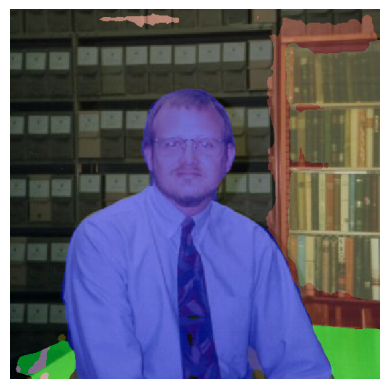

In [112]:
# run all upto this: Masud
# iterative check image and run
import numpy as np
from PIL import Image
img_ = 3
image_gen.image_gen(inputs_s[img_], pred[img_], 0.5,save_fig= None, palette='coco')

for l in (labels[img_].unique().cpu()):
    print(classes[l])
    
with torch.no_grad():
    x = text_feats_d[labels]
    y = image_feats_d
    x_time = torch.sqrt(1 / 1 + torch.sum(x**2, dim=-1))
    y_time = torch.sqrt(1 / 1 + torch.sum(y**2, dim=-1))

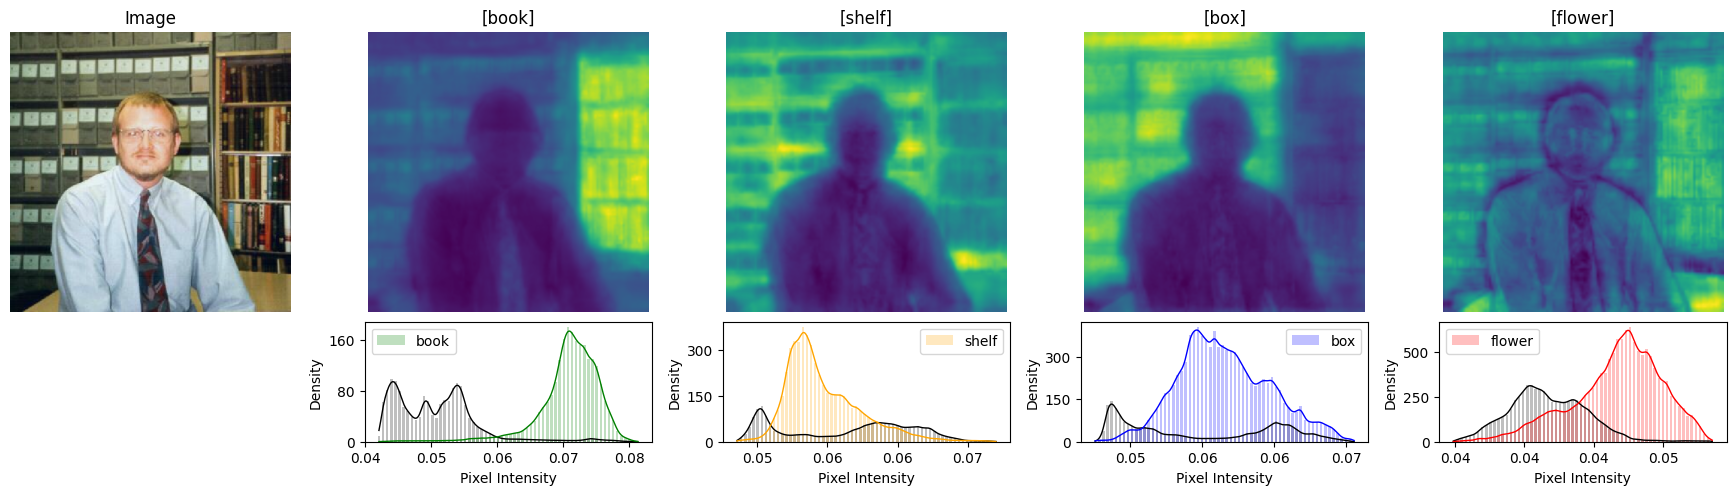

In [114]:
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
class_query = ['book', 'shelf', 'box', 'flower']
color_range = ['green', 'orange', 'blue', 'red']
figure_name = class_query[0]
fig, axs = plt.subplots(2, len(class_query)+1, figsize=((len(class_query)+1)*3.5, 5), gridspec_kw={'height_ratios': [3.5, 1.5]})

axs[0][0].imshow(np.transpose(inputs_s[img_].cpu(), (1, 2, 0)))
axs[0][0].set_title('Image')
axs[0][0].axis("off")

axs[1,0].axis('off')      # hide it
fig.delaxes(axs[1,0])


for q in range(len(class_query)):
    original_class = classes.index(class_query[0]) # what is the original class
    class_check = classes.index(class_query[q]) # check _classes.txt and subtract1
    mask_raw = (labels[img_] == original_class)
    angle_values = L.oxy_angle_full(y, text_feats_d[class_check].unsqueeze(0)) # exact angle corresponding to the prototypes.

    angle_preds= torch.exp(-angle_values[img_]/0.8).cpu()
    data = angle_preds.view(-1).numpy()

    # Plot histogram for each channel
    mask = mask_raw.cpu().view(-1).numpy()
    pixels_label1 = data[mask == 1]
    pixels_label0 = data[mask == 0]

    counts0, bins0 = np.histogram(pixels_label0, bins=64, density=True)
    counts1, bins1 = np.histogram(pixels_label1, bins=64, density=True)

    bin_centers = (bins0[:-1] + bins0[1:]) / 2
    bin_width   = bins0[1] - bins0[0]

    def smooth_line(x, y, sigma_bins=2.5, n_points=300):
        # Upsample
        x_fine = np.linspace(x.min(), x.max(), n_points)
        y_fine = np.interp(x_fine, x, y)

        # Gaussian kernel in "points" (approx bins since x is linear)
        ksize = int(6*sigma_bins) | 1  # odd length
        r = np.arange(ksize) - ksize//2
        kernel = np.exp(-0.5*(r / sigma_bins)**2)
        kernel /= kernel.sum()

        y_smooth = np.convolve(y_fine, kernel, mode='same')
        return x_fine, y_smooth

    x0, y0 = smooth_line(bin_centers, counts0, sigma_bins=3.0)
    x1, y1 = smooth_line(bin_centers, counts1, sigma_bins=3.0)


    # First subplot: imshow (taller, 5 units)
    axs[0][q+1].imshow(angle_preds)
    axs[0][q+1].set_title('['+class_query[q]+']')
    axs[0][q+1].axis("off")

    # Second subplot: plot (shorter, 2 units)
    axs[1][q+1].bar(bin_centers, counts0, width=0.6*bin_width, color='black', alpha=0.25)
    axs[1][q+1].bar(bin_centers, counts1, width=0.6*bin_width, color=color_range[q],   alpha=0.25, label=class_query[q])
    axs[1][q+1].plot(x0, y0, color='black', linewidth=1)
    axs[1][q+1].plot(x1, y1, color=color_range[q],   linewidth=1)
    axs[1][q+1].set_xlabel('Pixel Intensity')
    axs[1][q+1].set_ylabel('Density')
    axs[1][q+1].legend()

    axs[1][q+1].xaxis.set_major_locator(MaxNLocator(nbins=5))
    axs[1][q+1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axs[1][q+1].yaxis.set_major_locator(MaxNLocator(nbins=3))

plt.tight_layout()
plt.savefig('figure2/ade_'+figure_name+'.pdf', format='pdf')
plt.show()


In [115]:
from glob import glob
fig_files = glob('figure2/ade_*.pdf')
for fig_file in fig_files:
    print('\includegraphics[width=\linewidth]{supp_figures/' + fig_file.split('/')[1]+'}')

\includegraphics[width=\linewidth]{supp_figures/ade_sea.pdf}
\includegraphics[width=\linewidth]{supp_figures/ade_tree.pdf}
\includegraphics[width=\linewidth]{supp_figures/ade_building.pdf}
\includegraphics[width=\linewidth]{supp_figures/ade_car.pdf}
\includegraphics[width=\linewidth]{supp_figures/ade_road.pdf}
\includegraphics[width=\linewidth]{supp_figures/ade_stairs.pdf}
\includegraphics[width=\linewidth]{supp_figures/ade_bed.pdf}
\includegraphics[width=\linewidth]{supp_figures/ade_person.pdf}
\includegraphics[width=\linewidth]{supp_figures/ade_sand.pdf}
\includegraphics[width=\linewidth]{supp_figures/ade_window.pdf}
\includegraphics[width=\linewidth]{supp_figures/ade_lamp.pdf}
\includegraphics[width=\linewidth]{supp_figures/ade_rug.pdf}
\includegraphics[width=\linewidth]{supp_figures/ade_book.pdf}
\includegraphics[width=\linewidth]{supp_figures/ade_screen.pdf}
\includegraphics[width=\linewidth]{supp_figures/ade_mountain.pdf}
\includegraphics[width=\linewidth]{supp_figures/ade_snooke

In [38]:
from MERU_utils import manifold_conversion as mc
importlib.reload(mc)
im_poin = mc.lorentz_to_poincare(mc.spatial_to_lorentz(y))
poin_len = torch.sqrt((im_poin**2).sum(-1))

In [31]:
# an_aero = mc.masked_lorentz_mean_direct(y, labels == 21) # compute the mean after l2k mean k2l
mean_aero2 = mc.masked_lorentz_mean_klein(y, labels == 37)
dist_values = -L.pairwise_dist(y, mean_aero2[1:].unsqueeze(0))
angle_values = L.oxy_angle_full(y, mean_aero2[1:].unsqueeze(0)) 

In [23]:
# masud 2
original_class = 11 # what is the original class
class_check = 11 # check _classes.txt and subtract1
mask_raw = (labels[img_] == original_class)
angle_values = L.oxy_angle_full(y, text_feats_d[class_check].unsqueeze(0)) # exact angle corresponding to the prototypes. 

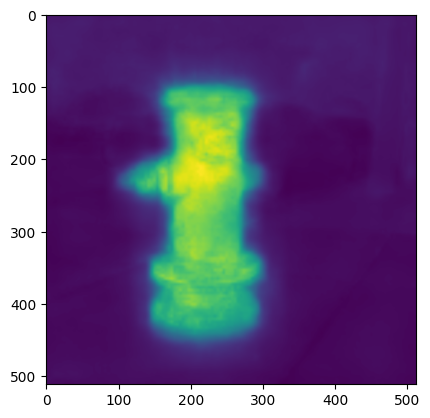

<Figure size 640x480 with 0 Axes>

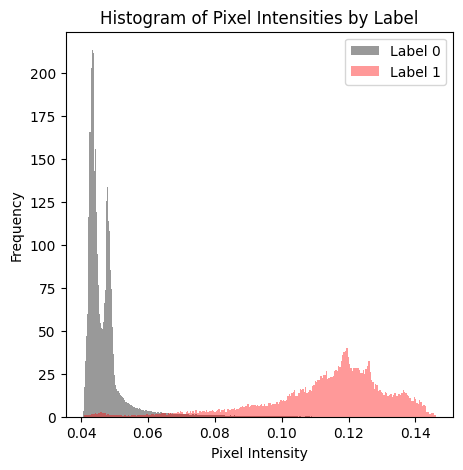

In [33]:
# plt.imshow(torch.exp(dist_values[img_]/0.5).cpu())
angle_preds= torch.exp(-angle_values[img_]/0.8).cpu()
plt.imshow(angle_preds) ; plt.show()
# plt.imshow(poin_len[img_].cpu())
plt.savefig('figure/Nonsense.svg', format = 'svg' )
# plot histogram too. 



data = angle_preds.view(-1).numpy()

# data = (data- data.min())/(data.max()- data.min()) # no scaling

# Plot histogram for each channel
mask = mask_raw.cpu().view(-1).numpy()

# Separate pixels by label
pixels_label1 = data[mask == 1]
pixels_label0 = data[mask == 0]

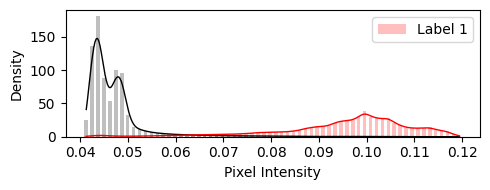

In [91]:

data = angle_preds.view(-1).numpy()

# data = (data- data.min())/(data.max()- data.min()) # no scaling

# Plot histogram for each channel
mask = mask_raw.cpu().view(-1).numpy()

# Separate pixels by label
pixels_label1 = data[mask == 1]
pixels_label0 = data[mask == 0]

counts0, bins0 = np.histogram(pixels_label0, bins=64, density=True)
counts1, bins1 = np.histogram(pixels_label1, bins=64, density=True)

bin_centers = (bins0[:-1] + bins0[1:]) / 2
bin_width   = bins0[1] - bins0[0]

plt.figure(figsize=(5, 2))
plt.bar(bin_centers, counts0, width=0.6*bin_width, color='black', alpha=0.25)
plt.bar(bin_centers, counts1, width=0.6*bin_width, color='red',   alpha=0.25, label='Label 1')

# --- build smooth lines (interpolation + Gaussian smoothing) ---
def smooth_line(x, y, sigma_bins=2.5, n_points=300):
    # Upsample
    x_fine = np.linspace(x.min(), x.max(), n_points)
    y_fine = np.interp(x_fine, x, y)

    # Gaussian kernel in "points" (approx bins since x is linear)
    ksize = int(6*sigma_bins) | 1  # odd length
    r = np.arange(ksize) - ksize//2
    kernel = np.exp(-0.5*(r / sigma_bins)**2)
    kernel /= kernel.sum()

    y_smooth = np.convolve(y_fine, kernel, mode='same')
    return x_fine, y_smooth

x0, y0 = smooth_line(bin_centers, counts0, sigma_bins=3.0)
x1, y1 = smooth_line(bin_centers, counts1, sigma_bins=3.0)

plt.plot(x0, y0, color='black', linewidth=1)
plt.plot(x1, y1, color='red',   linewidth=1)

plt.xlabel('Pixel Intensity')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()


In [59]:
angle_preds.shape

torch.Size([512, 512, 1])

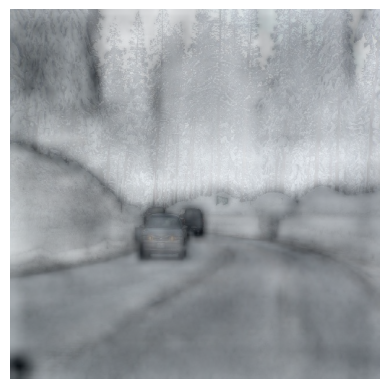

In [51]:

a_vals, a_idxs = torch.min(angles_full, dim=-1)   # angle values and angle indexes # a index provides another inference methods
p_embed = torch.sqrt(torch.sum(y**2, dim=-1))/(1+y_time) # hyperboloid to poincare projection # magnitude
# p_embed = poin_len

# plot helper
img_ = 18
orig_img = inputs_s[img_].cpu().permute(1,2,0)

def uq_plot(orig_img, val, img_ = img_, pow_ = 2, save_name = 0):
    w_img = 0.2
    # val = a_vals # the source of the uncertainty p_embed for distance, and a_vals for angle entailment values
    val_ = (val[img_] - val[img_].min())/(val[img_].max() - val[img_].min()).cpu()

    mask = val_.unsqueeze(-1).cpu()**pow_ # (H, W)
    # Blend with original image
    overlay =  w_img*orig_img  + (1 - w_img) * mask.cpu()
    plt.imshow(overlay)
    plt.axis("off")
    
    plt.savefig('figure/boundary44_coco' +str(save_name)+ '.svg', format = 'svg' )

    plt.show()
    
# uq_plot(orig_img, a_vals**5, pow_ = 1, save_name = 0)
uq_plot(orig_img, p_embed**1, pow_= 0.8, save_name = 1)

# uq_plot(orig_img, y_time)

# plt.imshow(torch.acosh(y_time[img_]).cpu())


In [38]:
p_embed.min()

tensor(0.6171, device='cuda:0')

In [34]:
with torch.no_grad():
    pred = model(inputs, None)["logits"] #
    pred = torch.argmax(pred, dim=-1)

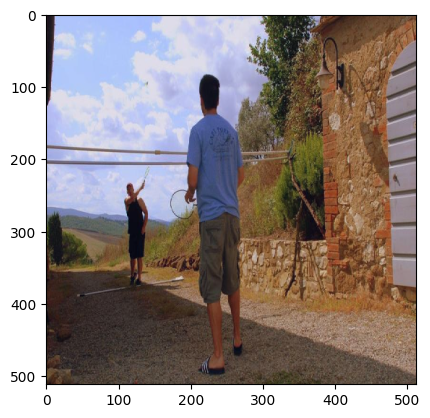

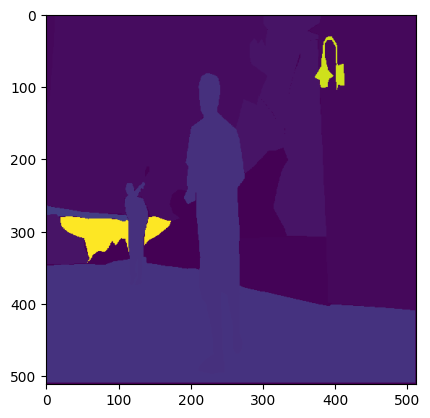

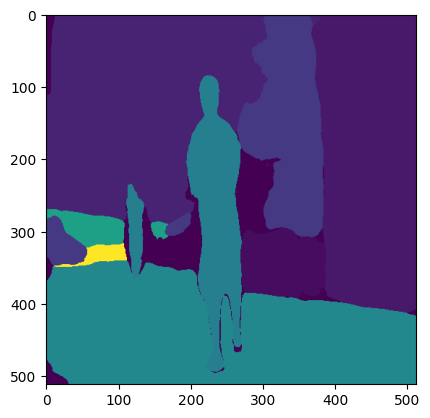

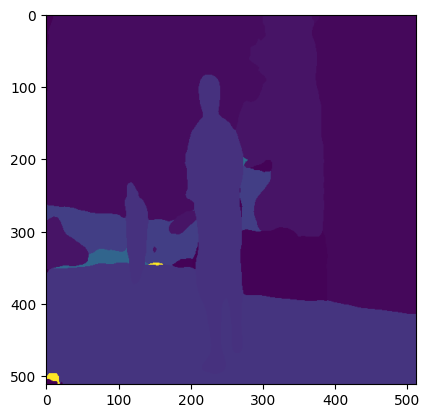

In [67]:
import matplotlib.pyplot as plt
# img_ = 21
inputs_s = (inputs - torch.min(inputs))/ (torch.max(inputs) - torch.min(inputs))
plt.imshow(inputs_s[img_].cpu().permute(1,2,0)); plt.show()
plt.imshow(labels[img_].int().cpu()); plt.show()
plt.imshow(pred[img_].int().cpu()); plt.show()
plt.imshow(a_idxs[img_].int().cpu()); plt.show()
# plt.imshow(labels[img_].int().cpu()-pred[img_].int().cpu()); plt.show()

double check these functions for correct results


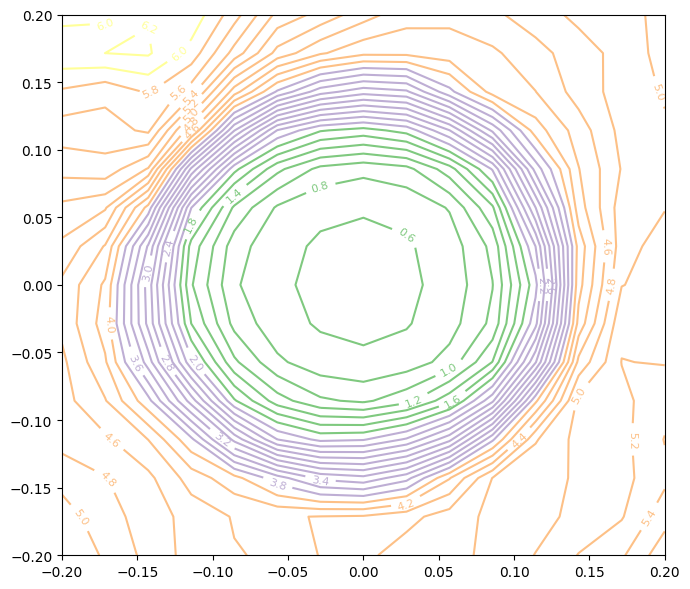

In [116]:
# loss surface visualization

import Utils_Loss_Vis.filt_norm_lv 
# normalized filter visualization

importlib.reload(Utils_Loss_Vis.filt_norm_lv)

from Utils_Loss_Vis.filt_norm_lv import get_filter_normalized_directions, perturb_model, plot_loss_contour_lines, loss_surface_for_modules
print('double check these functions for correct results')
# layers_to_plot = ['backbone']
layers_to_plot = ['encoder', 'decode_head']
a, b, Z_all = loss_surface_for_modules(model, layers_to_plot, inputs, labels, grid_size=15, span=0.2)
plot_loss_contour_lines(a, b, Z_all, f"Loss Surface — {layers_to_plot}", 'deeplabv3meru_coco_25.15')

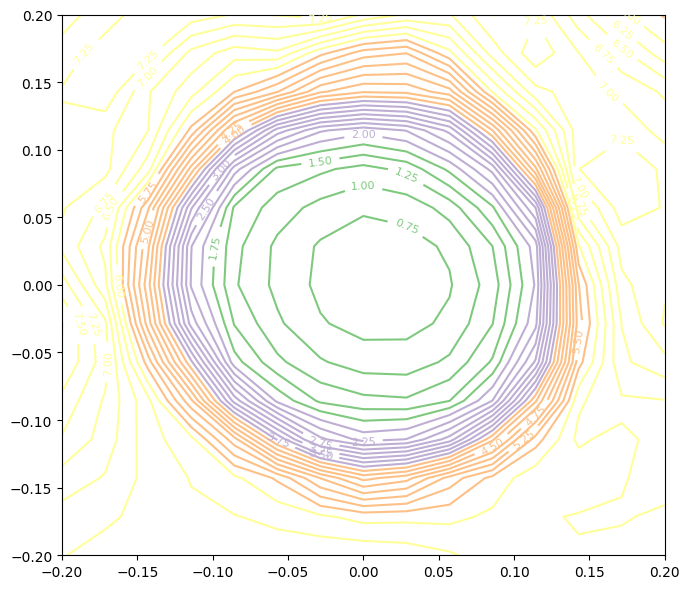

In [180]:

importlib.reload(Utils_Loss_Vis.filt_norm_lv)

from Utils_Loss_Vis.filt_norm_lv import get_filter_normalized_directions, perturb_model, plot_loss_contour_filled, plot_loss_contour_lines, loss_surface_for_modules

plot_loss_contour_lines(a, b, Z_all, f"Loss Surface — {layers_to_plot}", 'deeplabv3meru_coco_25.15')
